In [1]:
import os
import glob
import numpy as np

import cv2

import torch
from torch.utils import data

import torchvision

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# helper function for image IO
def load_image(path):
  # load an image into RGB format
  img = cv2.imread(path)
  img = img[:, :, ::-1]  # BGR -> RGB
  return img

def save_image(path, img):
  # save an RGB image into a file
  img = img.copy()[:,:,::-1]
  return cv2.imwrite(path, img)

def resize_image(img, new_size, interpolation):
    # resize an image into new_size (w * h) using specified interpolation
    # opencv has a weird rounding issue & this is a hacky fix
    # ref: https://github.com/opencv/opencv/issues/9096
    mapping_dict = {cv2.INTER_NEAREST: cv2.INTER_NEAREST_EXACT}
    if interpolation in mapping_dict:
        img = cv2.resize(
            img,
            new_size,
            interpolation=mapping_dict[interpolation]
        )
    else:
        img = cv2.resize(
            img,
            new_size,
            interpolation=interpolation
        )
    return img

In [2]:
# a simple dataset
class SimpleDataset(data.Dataset):
    """
    A simple dataset using PyTorch dataloader
    """
    def __init__(self, root_folder, file_ext, transforms=None):
        # root folder, split
        self.root_folder = root_folder
        self.transforms = transforms
        self.file_ext = file_ext

        # list all files
        file_list = glob.glob(os.path.join(root_folder, '*.{:s}'.format(file_ext)))
        self.file_list = file_list

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, index):
        # load img and label (from file name)
        filename = self.file_list[index]
        img = load_image(filename).astype(np.float32) / 255.0
        label = 1 if "cat" in os.path.basename(filename) else 0
        # apply data augmentation
        if self.transforms is not None:
            img  = self.transforms(img)
        return img, label

In [3]:
# simple data augmentation
class Compose(object):
    """
    Composes several transforms together.
    Args:
      transforms (list of ``Transform`` objects): list of transforms to compose.
    Example:
      >>> Compose([
      >>>     Scale(320),
      >>>     RandomSizedCrop(224),
      >>> ])
    """
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, img):
        for t in self.transforms:
            img = t(img)
        return img

    def __repr__(self):
        repr_str = ""
        for t in self.transforms:
            repr_str += t.__repr__() + '\n'
        return repr_str

class ToTensor(object):
    """Convert a ``numpy.ndarray`` image to tensor.
    Converts a numpy.ndarray (H x W x C) image in the range
    [0, 255] to a torch.FloatTensor of shape (C x H x W) in the range [0.0, 1.0].
    """
    def __call__(self, img):
        assert isinstance(img, np.ndarray)
        # convert image to tensor
        assert (img.ndim > 1) and (img.ndim <= 3)
        if img.ndim == 2:
            img = img[:, :, None]
            tensor_img = torch.from_numpy(
                np.ascontiguousarray(img.transpose((2, 0, 1)))
            )
        if img.ndim == 3:
            tensor_img = torch.from_numpy(
                np.ascontiguousarray(img.transpose((2, 0, 1)))
            )
        # backward compatibility
        if isinstance(tensor_img, torch.ByteTensor):
            return tensor_img.float().div(255.0)
        else:
            return tensor_img

class Resize(object):
    """
    Resize an input image into a fixed resolution.
    """
    def __init__(self, size):
        assert (
            isinstance(size, int)
            or (isinstance(size, collections.Iterable) and len(size) == 2)
           )
        if isinstance(size, int):
            self.size = (size, size)
        else:
            self.size = size
    
    def __call__(self, img):
        assert isinstance(img, np.ndarray)
        img = resize_image(img, self.size, cv2.INTER_LINEAR)
        return img

def imshow(img):
    npimg = img.numpy()
    plt.figure(); plt.axis('off'); plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
    return npimg

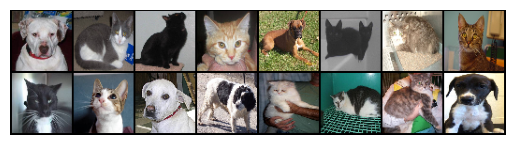

dog  	cat  	cat  	cat  	dog  	cat  	cat  	cat  
cat  	cat  	dog  	dog  	cat  	cat  	cat  	dog  



In [4]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

# image IO using PyTorch dataloader
# set up the transforms (make sure you convert numpy array to pytorch tensor)
transforms = []
transforms.append(Resize(64))
transforms.append(ToTensor())
comp_transforms = Compose(transforms)

# let us try a toy dataset
train_batch_size, test_batch_size = 16, 4
train_dataset = SimpleDataset('./data/mini_train', file_ext='jpg', transforms=comp_transforms)
val_dataset = SimpleDataset('./data/mini_val', file_ext='jpg', transforms=comp_transforms)
train_data_loader = torch.utils.data.DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True)
val_data_loader = torch.utils.data.DataLoader(val_dataset, batch_size=test_batch_size, shuffle=False)

# get some random training images
dataiter = iter(train_data_loader)
images, labels = next(dataiter)

# show images
nrow = train_batch_size // 2
imshow(torchvision.utils.make_grid(images, nrow=nrow))
classes = ("dog", "cat")
# print labels
output = ''
for i, j in enumerate(range(train_batch_size), 1):
    output += f'{classes[labels[j]]:5s}' + ['\t', '\n'][i % nrow == 0]
print(output)
del dataiter


In [5]:
# a simple neural network modified from PyTorch tutorial
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 8, 5, padding=2, stride=2)
        self.bn1 = nn.BatchNorm2d(8)
        self.conv2 = nn.Conv2d(8, 16, 5)
        self.bn2 = nn.BatchNorm2d(16)
        self.conv3 = nn.Conv2d(16, 32, 5)
        self.bn3 = nn.BatchNorm2d(32)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(32 * 5 * 5, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 2)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = Net()

In [6]:
# loss function for training
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(net.parameters(), lr=0.001)

# training loop
for epoch in range(6):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(train_data_loader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 50 == 49:    # print every 50 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 50:.3f}')
            running_loss = 0.0

print('Finished Training')

[1,    50] loss: 0.688
[1,   100] loss: 0.677
[1,   150] loss: 0.653
[1,   200] loss: 0.643
[1,   250] loss: 0.633
[1,   300] loss: 0.620
[1,   350] loss: 0.608
[2,    50] loss: 0.582
[2,   100] loss: 0.568
[2,   150] loss: 0.605
[2,   200] loss: 0.566
[2,   250] loss: 0.562
[2,   300] loss: 0.524
[2,   350] loss: 0.513
[3,    50] loss: 0.497
[3,   100] loss: 0.510
[3,   150] loss: 0.493
[3,   200] loss: 0.485
[3,   250] loss: 0.552
[3,   300] loss: 0.462
[3,   350] loss: 0.520
[4,    50] loss: 0.451
[4,   100] loss: 0.458
[4,   150] loss: 0.495
[4,   200] loss: 0.442
[4,   250] loss: 0.466
[4,   300] loss: 0.470
[4,   350] loss: 0.449
[5,    50] loss: 0.411
[5,   100] loss: 0.414
[5,   150] loss: 0.434
[5,   200] loss: 0.413
[5,   250] loss: 0.424
[5,   300] loss: 0.404
[5,   350] loss: 0.471
[6,    50] loss: 0.366
[6,   100] loss: 0.439
[6,   150] loss: 0.406
[6,   200] loss: 0.395
[6,   250] loss: 0.399
[6,   300] loss: 0.385
[6,   350] loss: 0.384
Finished Training


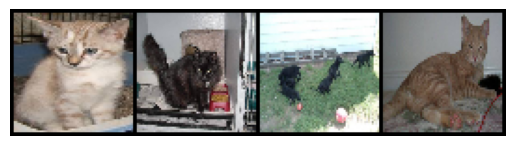

GroundTruth:  cat   cat   dog   cat  
Predicted  :  dog   cat   dog   cat  


In [9]:
# let us look at network outputs using the validation set
dataiter = iter(val_data_loader)
images, labels = next(dataiter)

# print images
imshow(torchvision.utils.make_grid(images, nrow=test_batch_size))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

# prediction using the trained network
outputs = net(images)
_, predicted = torch.max(outputs, 1)

print('Predicted  : ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(test_batch_size)))
del dataiter

In [10]:
# performance on the validation set
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in val_data_loader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the validation set: {100 * correct // total} %')

Accuracy of the network on the validation set: 73 %


In [11]:
correct

734